# Predicción de serie temporal de índices financieros

## Módulo 3 – Deep Learning
### Salomón Ramírez
#### Julio 2023

In [111]:
# biliotecas requeridas

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math

## Lectura de datos

In [3]:
# lectura de datos y conversión a serie de tiempo al usar un parser para las fechas

date_parser = lambda x: pd.to_datetime(x, format='%d-%b-%y')

df_sp500 = pd.read_csv('data/index-sp-500-ok.csv', parse_dates=[0], index_col=0)

display(df_sp500.head())
print(df_sp500.shape)

df_sp_bmv_ipc = pd.read_csv('data/index-sp-bmv-ipc-mxn.csv', parse_dates=[0], index_col=0)
display(df_sp_bmv_ipc.head())
print(df_sp_bmv_ipc.shape)

df_sp_bmv_total = pd.read_csv('data/index-bmv-total-mexico-tr-mxn.csv', parse_dates=[0], index_col=0)
display(df_sp_bmv_total.head())
print(df_sp_bmv_total.shape)

df_sp_global_bmi = pd.read_csv('data/index-global-bmi.csv', parse_dates=[0], index_col=0)
display(df_sp_global_bmi.head())
print(df_sp_global_bmi.shape)




,S&P 500 (TR)
Index Name,
2023-07-18,9790.199590
2023-07-17,9721.025524
2023-07-14,9683.685534
2023-07-13,9693.297790
2023-07-12,9610.874778


(8528, 1)


,S&P/BMV IPC
Index Name,
2023-07-18,54036.27448
2023-07-17,53623.26734
2023-07-14,53770.80282
2023-07-13,54244.01314
2023-07-12,53956.70953


(11188, 1)


,S&P/BMV Total Mexico Index (MXN) TR
Index Name,
2023-07-18,183.873826
2023-07-17,182.495665
2023-07-14,183.058695
2023-07-13,184.630505
2023-07-12,183.402600


(2734, 1)


,S&P Global BMI (USD)
Index Name,
2023-07-18,341.263545
2023-07-17,339.272722
2023-07-14,338.868883
2023-07-13,338.992279
2023-07-12,335.305709


(7448, 1)


## Merge de dataframes

In [4]:
# merge de datasets
merged_df = pd.merge(df_sp500, df_sp_bmv_ipc, on='Index Name', how='outer')
display(merged_df.head())

,S&P 500 (TR),S&P/BMV IPC
Index Name,,
2023-07-18,9790.199590,54036.27448
2023-07-17,9721.025524,53623.26734
2023-07-14,9683.685534,53770.80282
2023-07-13,9693.297790,54244.01314
2023-07-12,9610.874778,53956.70953


In [5]:
#final_df = pd.merge(merged_df, df_sp_global_bmi, on='Index Name', how='outer')
#display(merged_df.head())

In [6]:
merged_df = pd.merge(merged_df, df_sp_bmv_total, on='Index Name', how='outer')
display(merged_df.head())

,S&P 500 (TR),S&P/BMV IPC,S&P/BMV Total Mexico Index (MXN) TR
Index Name,,,
2023-07-18,9790.199590,54036.27448,183.873826
2023-07-17,9721.025524,53623.26734,182.495665
2023-07-14,9683.685534,53770.80282,183.058695
2023-07-13,9693.297790,54244.01314,184.630505
2023-07-12,9610.874778,53956.70953,183.402600


In [7]:
print(merged_df.shape)
merged_df.isna().sum()

(11437, 3)


S&P 500 (TR)                           2909
S&P/BMV IPC                             249
S&P/BMV Total Mexico Index (MXN) TR    8703
dtype: int64

## Limpieza de datos

In [8]:
# limpieza de datos (ya que las bolsas de México y Estados Unidos tienen  holidays diferentes, 
# nos quedaremos con filas que tengan sólo datos para los 3 índices)
dataClean=merged_df.dropna()
dataClean.shape

(2658, 3)

In [9]:
dataClean.index.name='date'
dataClean

,S&P 500 (TR),S&P/BMV IPC,S&P/BMV Total Mexico Index (MXN) TR
date,,,
2023-07-18,9790.199590,54036.27448,183.873826
2023-07-17,9721.025524,53623.26734,182.495665
2023-07-14,9683.685534,53770.80282,183.058695
2023-07-13,9693.297790,54244.01314,184.630505
2023-07-12,9610.874778,53956.70953,183.402600
...,...,...,...
2012-09-10,2491.114930,39991.19000,100.650036
2012-09-07,2506.366522,40043.87000,100.713636
2012-09-06,2496.123467,39987.06000,100.582347


In [10]:
#dataClean = data.rename(columns = {'S&P 500 (TR)':'sp500', 'S&P/BMV IPC':'spbmvipc', 'S&P/BMV Total Mexico Index (MXN) TR':'spbmvtotal'})
#dataClean = data.copy()
print(dataClean.head())
print(dataClean.shape)

            S&P 500 (TR)  S&P/BMV IPC  S&P/BMV Total Mexico Index (MXN) TR
date                                                                      
2023-07-18   9790.199590  54036.27448                           183.873826
2023-07-17   9721.025524  53623.26734                           182.495665
2023-07-14   9683.685534  53770.80282                           183.058695
2023-07-13   9693.297790  54244.01314                           184.630505
2023-07-12   9610.874778  53956.70953                           183.402600
(2658, 3)


In [11]:
dataClean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2023-07-18 to 2012-09-04
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   S&P 500 (TR)                         2658 non-null   float64
 1   S&P/BMV IPC                          2658 non-null   float64
 2   S&P/BMV Total Mexico Index (MXN) TR  2658 non-null   float64
dtypes: float64(3)
memory usage: 83.1 KB


In [12]:
dataClean.iloc[0]

S&P 500 (TR)                            9790.199590
S&P/BMV IPC                            54036.274480
S&P/BMV Total Mexico Index (MXN) TR      183.873826
Name: 2023-07-18 00:00:00, dtype: float64

In [13]:
dataClean.loc['2023-02-03']

S&P 500 (TR)                            8820.465947
S&P/BMV IPC                            54049.054010
S&P/BMV Total Mexico Index (MXN) TR      181.302666
Name: 2023-02-03 00:00:00, dtype: float64

## Visualización del dataset

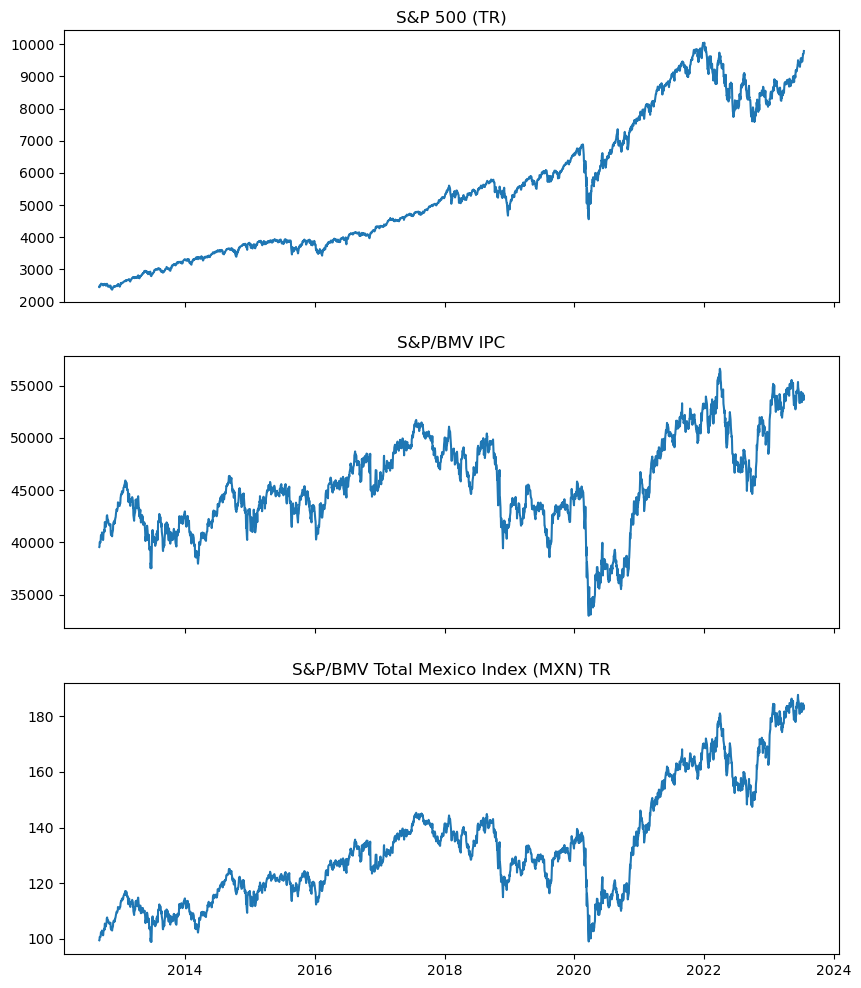

In [14]:
# visualización del dataset: tres series de datos. observar que cada uno tiene un rango de valores muy diferente.

fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

i = 0
for c in list(dataClean):
    axs[i].plot(dataClean[c])
    axs[i].set_title(c)
    i += 1
plt.show()

## Escalamiento

In [16]:
# escalamos los datos on un MinMax scaler, que escalará los datos en un rango de 0 a 1 muy
# apropiado para usar en la red neuronal

#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler = scaler.fit(dataClean)
df_for_training_scaled = scaler.transform(dataClean)

In [17]:
df_for_training_scaled[:,0]

array([0.96612346, 0.9571177 , 0.95225641, ..., 0.01650855, 0.00995766,
       0.01021708])

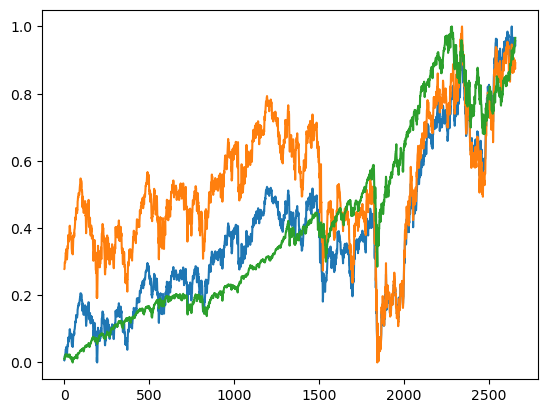

In [18]:
# invertimos el arreglo de numpy porque, vieniendo del dataframe, las fechas comenzaban por la m[as reciente y as[i lo recibi[o numpy
df_for_training_scaled = np.flip(df_for_training_scaled)
plt.plot(df_for_training_scaled)

## Construcción de Dataset

In [19]:
look_back=3
def create_dataset(x, look_back=1):
    dataX, dataY = [], []
    for i in range(len(x)-look_back-1):
        #a = x[i:(i+look_back), 0]
        a = x[i:(i+look_back)]
        dataX.append(a)
        #dataY.append(x[i + look_back, 0])
        dataY.append(x[i + look_back])
    return np.array(dataX), np.array(dataY)

## División Train/Test

In [20]:
train_ratio = 0.7

train_size = int(len(df_for_training_scaled) * train_ratio)
test_size = len(df_for_training_scaled) - train_size
train, test = df_for_training_scaled[0:train_size,:], df_for_training_scaled[train_size:len(df_for_training_scaled),:]

# ----- Generamos los conjuntos X,Y de entrenamiento y prueba -----
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# ----- reshape input to be [samples, time steps, features] -----
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
#print(f"Shape of X_train: {X_train.shape}")
#print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (1856, 3, 3)
Shape of X_test: (794, 3, 3)


## Modelo

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# ------ Creamos el modelo ------
def buildModel():
    model = Sequential()
    model.add(LSTM(800, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(800))
    model.add(Dense(Y_train.shape[1]))
    return model




## Entrenamiento

In [22]:
print('look_back:',look_back)
model = buildModel()
model.summary()

opt = optimizers.Adam(learning_rate=0.0001)
# ------ Compilamos el modelo ------
model.compile(loss='mean_squared_error', metrics=['mae'], optimizer=opt)

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1,
                    validation_split=0.1,callbacks=[es])

look_back: 3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 800)            2572800   
                                                                 
 dropout (Dropout)           (None, 3, 800)            0         
                                                                 
 lstm_1 (LSTM)               (None, 800)               5123200   
                                                                 
 dense (Dense)               (None, 3)                 2403      
                                                                 
Total params: 7,698,403
Trainable params: 7,698,403
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
53/53 [==============================] - 9s 76ms/step - loss: 0.0403 - mae: 0.1443 - val_loss: 0.0239 - val_mae: 0.1274
Epoch 2/50
53/53 [================

## Obtenemos las predicciones y evaluamos el desempeño de la red

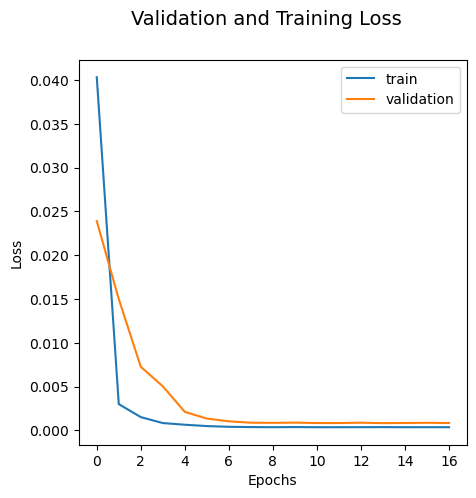

In [23]:
plt.figure(figsize=(5, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Predicciones

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

25/25 [==============================] - 1s 14ms/step


In [25]:
train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform([Y_test])

## Ejecución dato por dato para manipular los datos de entrada (work in progress)

In [26]:
# Reiniciando el estado oculto de la red
#model.reset_states()

In [27]:
X_test[0]

array([[0.04308997, 0.03364422, 0.43526117],
       [0.07314879, 0.07523171, 0.45521907],
       [0.06376566, 0.06398058, 0.44156267]])

In [28]:
# input_data = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))
inputData = X_test[0]
inputData = np.reshape(inputData, (1,inputData.shape[0], inputData.shape[1] ))
print(inputData)


[[[0.04308997 0.03364422 0.43526117]
  [0.07314879 0.07523171 0.45521907]
  [0.06376566 0.06398058 0.44156267]]]


In [29]:
nextData_t1 = model.predict(inputData)
nextData_t1

1/1 [==============================] - 0s 22ms/step


array([[0.06909798, 0.06825969, 0.4321399 ]], dtype=float32)

In [30]:
X_test[1]

array([[0.07314879, 0.07523171, 0.45521907],
       [0.06376566, 0.06398058, 0.44156267],
       [0.04422026, 0.03924939, 0.41857566]])

In [31]:
print(X_test[1])
real = X_test[1].copy()
real[2] = nextData_t1[0]
print(real)
real = np.reshape(real, (1,real.shape[0], real.shape[1] ))
print(real)

[[0.07314879 0.07523171 0.45521907]
 [0.06376566 0.06398058 0.44156267]
 [0.04422026 0.03924939 0.41857566]]
[[0.07314879 0.07523171 0.45521907]
 [0.06376566 0.06398058 0.44156267]
 [0.06909798 0.06825969 0.4321399 ]]
[[[0.07314879 0.07523171 0.45521907]
  [0.06376566 0.06398058 0.44156267]
  [0.06909798 0.06825969 0.4321399 ]]]


In [32]:
nextData_t2 = model.predict(real)
print(nextData_t2)

1/1 [==============================] - 0s 27ms/step
[[0.08144978 0.08531275 0.43703997]]


# Evaluando el modeldo

In [33]:
print(model.evaluate(X_train, Y_train))
print(model.evaluate(X_test, Y_test))

58/58 [==============================] - 1s 18ms/step - loss: 4.0671e-04 - mae: 0.0141
[0.000406706181820482, 0.014123702421784401]
25/25 [==============================] - 0s 15ms/step - loss: 0.0011 - mae: 0.0258
[0.0010626149596646428, 0.02579336054623127]


In [113]:
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[0]))
print('Train Score RMSE: %.4f' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[0]))
print('Test Score RMSE: %.4f' % (test_score))

Train Score RMSE: 523538320.8571
Test Score RMSE: 401360326.6320


In [115]:
train_score_mape = (mean_absolute_percentage_error(Y_train[0], train_predict[0]))
print('Train Score MAPE: %.4f' % (train_score_mape))
test_score_mape = (mean_absolute_percentage_error(Y_test[0], test_predict[0]))
print('Test Score MAPE: %.4f' % (test_score_mape))

Train Score MAPE: 86740.1293
Test Score MAPE: 315631.7913


In [35]:
# Train Score RMSE: 22983.07
# Test Score RMSE: 20028.29

In [36]:
df_for_training_scaled.shape

(2658, 3)

# Prediciendo con el modelo

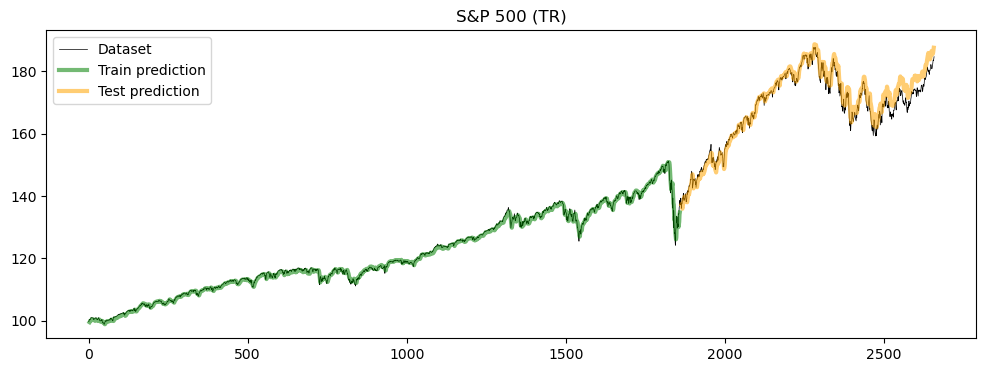

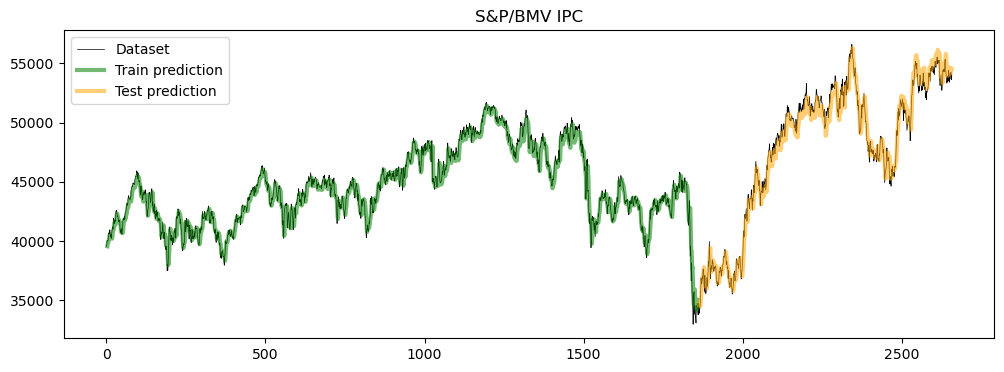

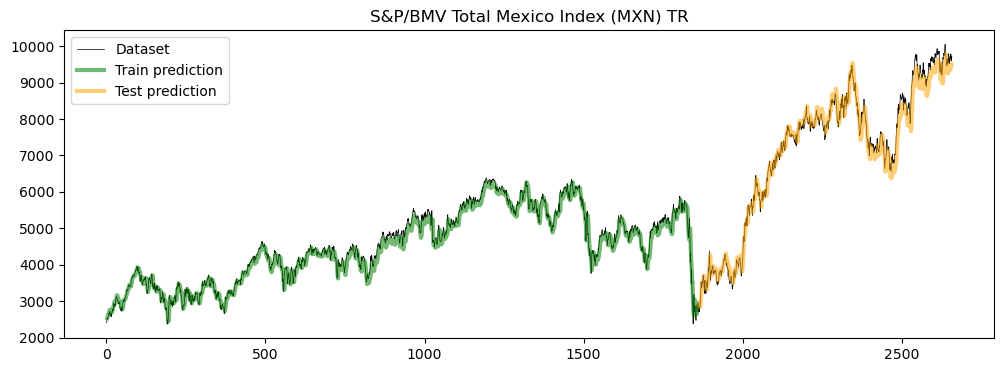

In [37]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataClean)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataClean)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataClean)-1, :] = test_predict

# plot baseline and predictions
for i in range(df_for_training_scaled.shape[1])[::-1]:
    plt.figure(figsize=(12,4))
    plt.plot(scaler.inverse_transform(df_for_training_scaled)[:,i],label='Dataset',linestyle='solid',color='black', linewidth=.5)
    plt.plot(trainPredictPlot[:,i],label='Train prediction',color='green',linewidth=3,alpha=0.55)
    plt.plot(testPredictPlot[:,i],label='Test prediction',color='orange',linewidth=3,alpha=0.55)
    plt.title(list(dataClean)[::-1][i])
    plt.legend(loc='best')
    plt.show()

In [108]:
look_back

3

In [110]:
#test_features = X_test.reshape((X_test.shape[0], 3, X_test.shape[1]))
test_features = X_test.reshape((X_test.shape[0], look_back, X_test.shape[1]))
mvmae = model.evaluate(test_features, Y_test, verbose=1)
print("Multi Variate MAE",mvmae)

25/25 [==============================] - 0s 16ms/step - loss: 0.0011 - mae: 0.0258
Multi Variate MAE [0.0010626149596646428, 0.02579336054623127]


(794,)
(794,)
S&P 500 (TR) RMSE: 2.6669
S&P 500 (TR) MAPE: 1.2317%
S&P 500 (TR) MAE: 2.0694


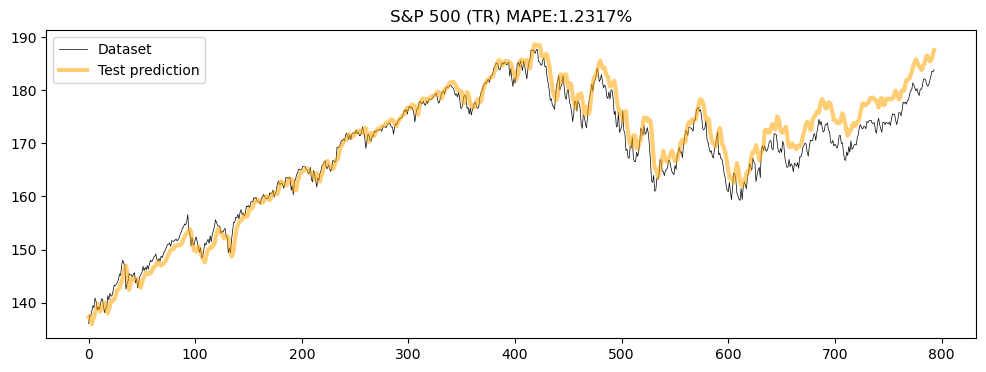

(794,)
(794,)
S&P/BMV IPC RMSE: 821.5216
S&P/BMV IPC MAPE: 1.3969%
S&P/BMV IPC MAE: 666.6804


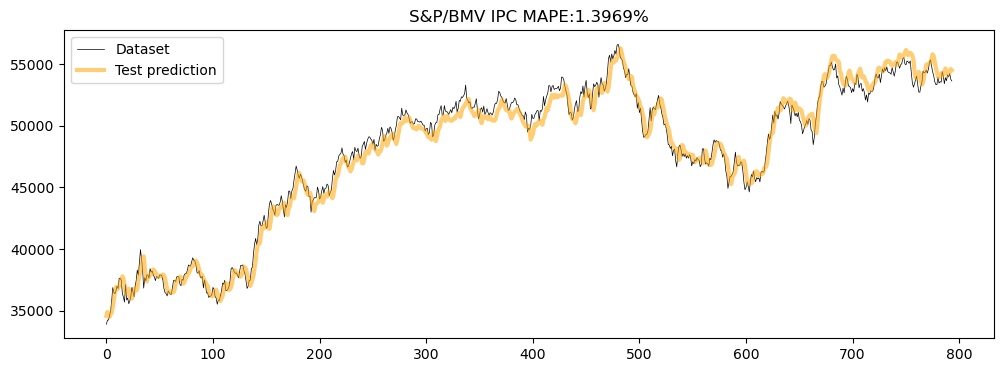

(794,)
(794,)
S&P/BMV Total Mexico Index (MXN) TR RMSE: 252.3841
S&P/BMV Total Mexico Index (MXN) TR MAPE: 2.8847%
S&P/BMV Total Mexico Index (MXN) TR MAE: 198.8812


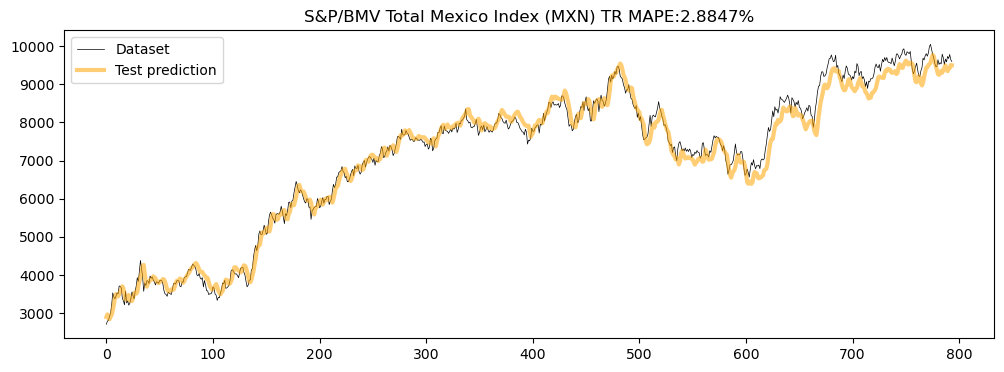

In [95]:
# MAPE test

# plot baseline and predictions
for i in range(df_for_training_scaled.shape[1])[::-1]:
    
    actual=scaler.inverse_transform(df_for_training_scaled)[len(train_predict)+(look_back*2)+1:len(dataClean)-1,i]#[len(train_predict)+look_back:,i]
    predicted=test_predict[:,i]
    
    print(actual.shape)
    print(predicted.shape)
        
    plt.figure(figsize=(12,4))
    plt.plot(actual,label='Dataset',linestyle='solid',color='black', linewidth=.5)
    #plt.plot(trainPredictPlot[:,i],label='Train prediction',color='green',linewidth=3,alpha=0.55)
#    plt.plot(testPredictPlot[:,i],label='Test prediction',color='orange',linewidth=3,alpha=0.55)
    plt.plot(predicted,label='Test prediction',color='orange',linewidth=3,alpha=0.55)
    
    
    indexName = list(dataClean)[::-1][i]
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    formattedRmse = "{:.4f}".format(rmse)
    print(indexName,"RMSE:",formattedRmse)
        
    # MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    formattedMape = "{:.4f}".format(mape)+"%"
    print(indexName,"MAPE:",formattedMape)
    
    # MAE
    #mae = np.mean(np.abs(actual - predicted))
    mae = mean_absolute_error(actual, predicted)
    formattedMae = "{:.4f}".format(mae)
    print(indexName,"MAE:",formattedMae)
    
    plt.title(indexName+" MAPE:"+formattedMape)
    plt.legend(loc='best')
    plt.show()

(1856,)
(1856,)
S&P 500 (TR) RMSE: 0.8240
S&P 500 (TR) MAPE: 0.4536%
S&P 500 (TR) MAE: 0.5587


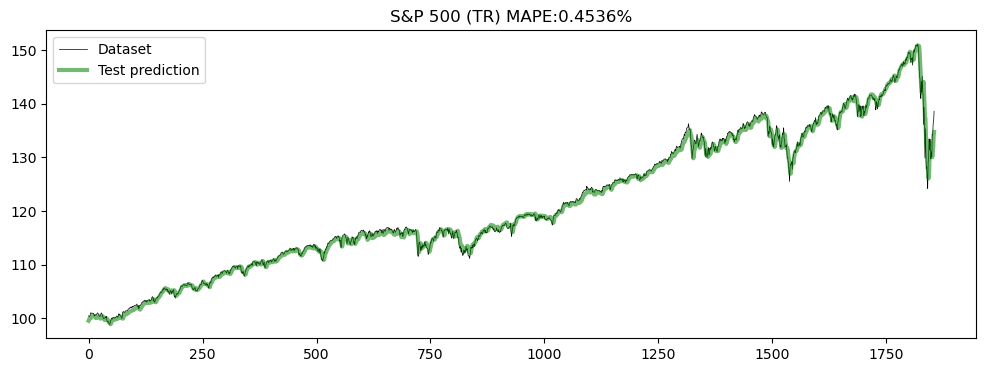

(1856,)
(1856,)
S&P/BMV IPC RMSE: 625.1271
S&P/BMV IPC MAPE: 1.0729%
S&P/BMV IPC MAE: 471.6855


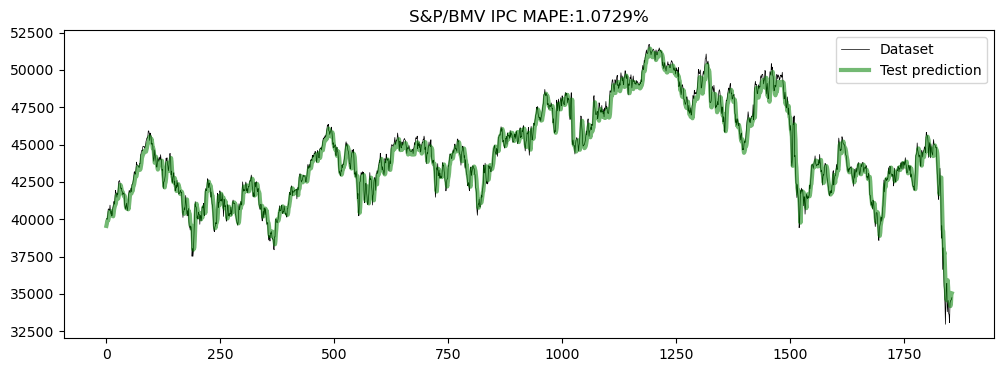

(1856,)
(1856,)
S&P/BMV Total Mexico Index (MXN) TR RMSE: 160.2294
S&P/BMV Total Mexico Index (MXN) TR MAPE: 2.8245%
S&P/BMV Total Mexico Index (MXN) TR MAE: 123.9266


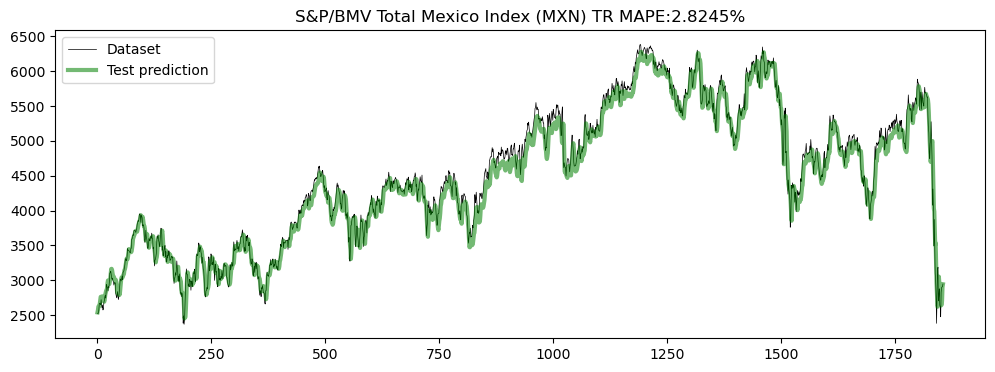

In [96]:
#MAPE Train:

# plot baseline and predictions
for i in range(df_for_training_scaled.shape[1])[::-1]:
    
    actual=scaler.inverse_transform(df_for_training_scaled)[look_back:len(train_predict)+look_back,i]#[len(train_predict)+look_back:,i]
    predicted=train_predict[:,i]
    
    print(actual.shape)
    print(predicted.shape)
    
   
    plt.figure(figsize=(12,4))
    plt.plot(actual,label='Dataset',linestyle='solid',color='black', linewidth=.5)
    #plt.plot(trainPredictPlot[:,i],label='Train prediction',color='green',linewidth=3,alpha=0.55)
#    plt.plot(testPredictPlot[:,i],label='Test prediction',color='orange',linewidth=3,alpha=0.55)
    plt.plot(predicted,label='Test prediction',color='green',linewidth=3,alpha=0.55)
    
    indexName = list(dataClean)[::-1][i]
    
    # RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    formattedRmse = "{:.4f}".format(rmse)
    print(indexName,"RMSE:",formattedRmse)
        
    # MAPE
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    formattedMape = "{:.4f}".format(mape)+"%"
    print(indexName,"MAPE:",formattedMape)
    
    # MAE
    #mae = np.mean(np.abs(actual - predicted))
    mae = mean_absolute_error(actual, predicted)
    formattedMae = "{:.4f}".format(mae)
    print(indexName,"MAE:",formattedMae)
    
    plt.title(indexName+" MAPE:"+formattedMape)
    plt.legend(loc='best')
    plt.show()